<a href="https://colab.research.google.com/github/PedroAdair/TesisMaestria/blob/main/avance_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#0. Instalación de paqueterias importantes

In [2]:
#@title networkx
!pip install networkx 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#@title Igraph (1.6.7)
!pip install igraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 81.7 MB/s eta 0:00:00


In [1]:
#@title gower (0.1.2)
!pip install gower 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Cargar los paquetes

In [27]:
import gower
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import igraph as ig
import networkx as nx

from sklearn.metrics.cluster import adjusted_rand_score, rand_score
from sklearn.metrics import jaccard_score
import networkx as nx
import matplotlib.pyplot as plt
from PIL import Image

#1. Construcción del grafo

La primer tarea consiste en construir un grafo a partir de la base de datos que se tiene previemente, como nuestros registros contienen observaciones numericas y categoricas, se opta por usar el coeficiente de similitud de Gower.

In [5]:
#link donde se encuentra la base de datos
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

# leer el archivo CSV de la base de datos adult
df = pd.read_csv(url, header=None)

In [6]:
#Para estos primeros resultados, solo trabajare con n=100
n = 100
df  = df.head(n)

In [7]:
matriz_distancias = gower.gower_matrix(df)
matriz_distancias

array([[0.        , 0.31261942, 0.31625032, ..., 0.45070857, 0.503844  ,
        0.39384323],
       [0.31261942, 0.        , 0.4071618 , ..., 0.34162003, 0.44175005,
        0.4847547 ],
       [0.31625032, 0.4071618 , 0.        , ..., 0.34806943, 0.36541176,
        0.3442596 ],
       ...,
       [0.45070857, 0.34162003, 0.34806943, ..., 0.        , 0.49986997,
        0.49014324],
       [0.503844  , 0.44175005, 0.36541176, ..., 0.49986997, 0.        ,
        0.576338  ],
       [0.39384323, 0.4847547 , 0.3442596 , ..., 0.49014324, 0.576338  ,
        0.        ]], dtype=float32)

Visualicemos esto con el siguiente mapa de calor

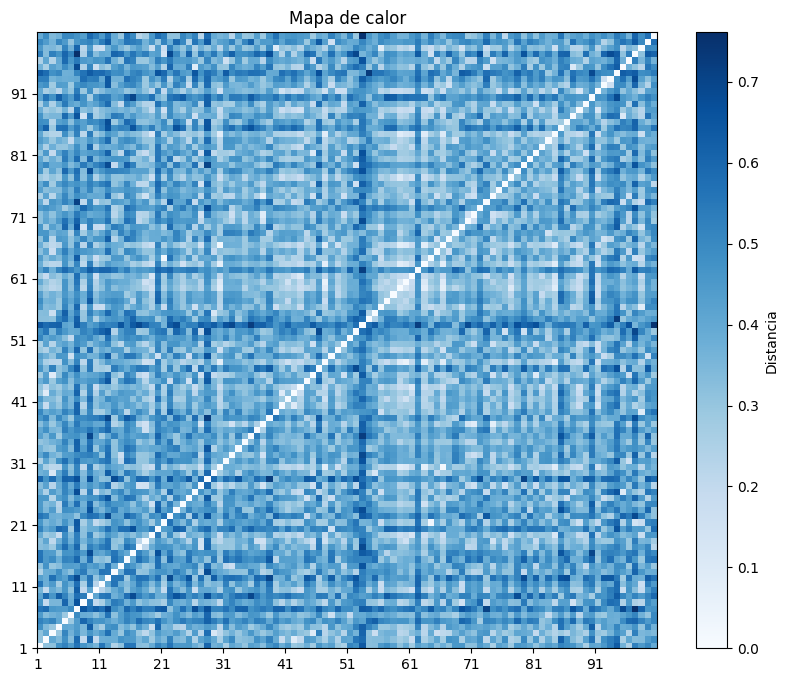

In [8]:
#@title mapa de calor de la matriz de distancias
def generar_mapa_calor(matriz):
    # Creamos la figura y el eje
    fig, ax = plt.subplots(figsize=(10, 8))

    # Generamos el mapa de calor a partir de la matriz
    heatmap = ax.pcolor(matriz, cmap=plt.cm.Blues)

    # Configuramos los ticks de los ejes x e y
    xticks = np.arange(0, matriz.shape[1], 10)
    yticks = np.arange(0, matriz.shape[0], 10)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

    # Agregamos las etiquetas correspondientes a los ticks de los ejes x e y
    ax.set_xticklabels(np.arange(1, matriz.shape[1]+1, 10))
    ax.set_yticklabels(np.arange(1, matriz.shape[0]+1, 10))

    # Agregamos una barra de color para indicar la escala de valores
    barra_color = plt.colorbar(heatmap)
    barra_color.set_label('Distancia')

    # Agregamos un título al mapa de calor
    ax.set_title('Mapa de calor')

    # Mostramos el mapa de calor generado
    plt.show()

# Ejemplo de uso
generar_mapa_calor(matriz_distancias)

De manara equivalente, el histograma de las distancias entre nodos es el siguiente

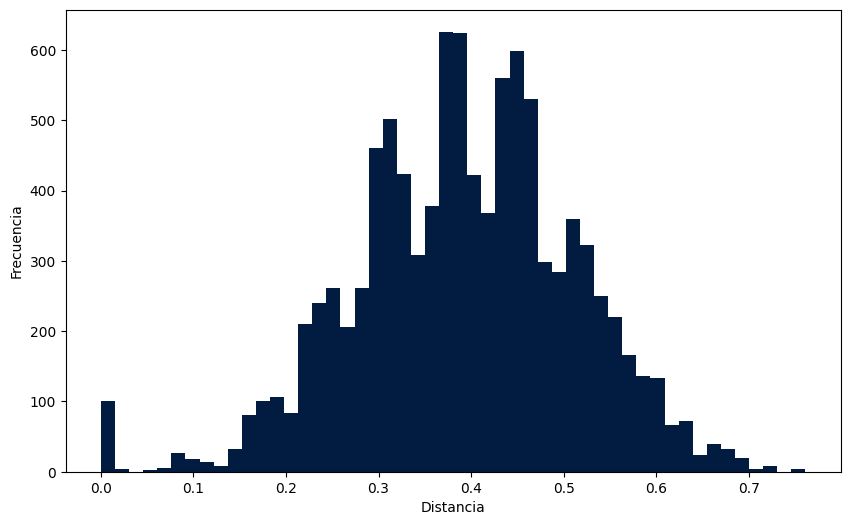

In [48]:
bar_color = (1/255, 28/255, 64/255)  # Normalizar los valores RGB de 0-255 a 0-1  
flat_matriz_distancias = matriz_distancias.flatten()
plt.figure(figsize=(10, 6))
plt.hist(flat_matriz_distancias,bins=50, color=bar_color)
#plt.title('Distancias de Gower sobre el conjunto "Adult"')
plt.xlabel('Distancia')
plt.ylabel('Frecuencia')
plt.show()

##Eficiencia Global
Surge aqui un nuevo reto: ¿a partir de que umbral definimos que 2 registros (vértices) tienen una arista en común? 

Creamos un grafo totalmente conectado con $n=100$ vértices y vamos eliminando aquellas aristas que corresponden a los elementos con distancias mayores que obtuvimos en la amtriz de Gower hasta alcanzar una eficiencia global de 0.8.

In [49]:
#Crea el grafo completo
g = nx.complete_graph(n)
# Obtener umbral correspondiente al percentil 80 de las distancias
threshold = np.percentile(np.sort(matriz_distancias.flatten())[::-1], 60)
print(f"threshold: {threshold}")
# Calcular eficiencia global inicial
efficiency = nx.algorithms.global_efficiency(g)
print(f"Eficiencia inicial: {efficiency}")

threshold: 0.43060379028320306
Eficiencia inicial: 1.0


In [50]:
# Eliminar aristas cuya distancia sea mayor que el umbral
for u, v in g.edges():
    if matriz_distancias[u][v] > threshold:
        #print(matriz_distancias[u][v])
        g.remove_edge(u, v)

# Calcular eficiencia global
efficiency = nx.algorithms.global_efficiency(g)
# Imprimir la eficiencia global final
print(f"La eficiencia global alcanzada fue de: {efficiency}")

La eficiencia global alcanzada fue de: 0.797407407407407


Finalmente, mostramos el grafo obtenido

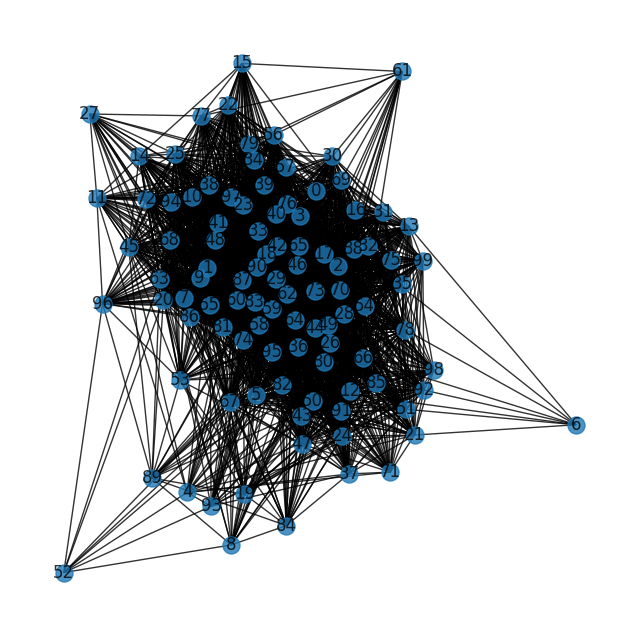

In [51]:
# Dibujar el grafo coloreando cada comunidad de un color distinto
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(g, seed=2023) 
nx.draw_networkx(g, pos=pos, with_labels=True, node_size=150, alpha=0.8, edge_color='k')

plt.axis('off')
plt.show()

In [52]:
# Obtener número de vértices y aristas
print("Número de vértices:", nx.number_of_nodes(g))
print("Número de aristas:", nx.number_of_edges(g))

Número de vértices: 100
Número de aristas: 2950


In [53]:
G_reducido = g

Considerando que un grafo totalmento conectado con 100  nodos tiene un total de 4950 aristas, hemos obtenido un grafo que tiene una eficiencia global de 0.8 con 2,000 conecciones menos.

#2. Analisis preeliminar

##2.1 Redes Sinteticas

In [14]:
import igraph as ig
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

El primer paso consiste en construir de manera artificial un grafo con comunidades. Para ello, con la función `crear_matrices_adyacencia` se parte de una lista y genera tantas comunidades como la longitud de la lista, y cada una de ellas del tamaño indicado en la $j$-esima componente.

Posteriormente se trabajan estas matrices para cosntruir una matriz por bloques donde agregamos conecciones entre los vertices de la red de manera aleatoria con una función bonomial con una  probabilidad $p$.

 Esto produce una matriz de adyacencia con la cual la función `from_matrix_to_Grahp` construye y muestra la red obtenida con ayuda de `pinta_comunidades`

In [15]:
#@title Redes sinteticas
import numpy as np

#La primer etapa consiste en crear los "bloques" en las matrices de adyacencia que corresponen a las comunidades,
#las conecciones se realizan basados en una distribución 
def crear_matrices_adyacencia(lista):
    matrices = []
    for n in lista:
        m = np.random.randint(2, size=(n, n))
        np.fill_diagonal(m, 0)
        matriz_adyacencia = np.triu(m, k=1) + np.triu(m, k=1).T
        matrices.append(matriz_adyacencia)
    return matrices

#Posteriormente se unen estos bloques en una sola matriz y los bloques fuera de la diagonal se agregan conecciones 
#basados en una distribución binomial con parametro "p"
def unir_matrices_adyacencia(matrices, p):
    n = len(matrices)
    bloques = []
    for i in range(n):
        fila = []
        for j in range(n):
            if i == j:
                fila.append(matrices[i])
            else:
                fila.append(np.zeros((len(matrices[i]), len(matrices[j]))))
        bloques.append(np.hstack(fila))
    matriz_completa = np.vstack(bloques)

    # Agregar valores de p simétricos fuera de los bloques diagonales
    for i in range(n):
        for j in range(i+1, n):
            filas = slice(sum([len(m) for m in matrices[:i]]), sum([len(m) for m in matrices[:i+1]]))
            columnas = slice(sum([len(m) for m in matrices[:j]]), sum([len(m) for m in matrices[:j+1]]))
            simetrico = np.random.binomial(1, p, (len(matrices[i]), len(matrices[j])))
            matriz_completa[filas, columnas] = simetrico
            matriz_completa[columnas, filas] = simetrico.T

    return matriz_completa

In [16]:
#@title from_matrix_to_Grahp
def from_matrix_to_Grahp(matriz_adyacencia):
  """
  recibe una matriz de adyacencia  y construye en grafo
  """
  # Crear un objeto Grafo vacío
  grafo = nx.Graph()

  # Agregar nodos al grafo
  nodos = range(matriz_adyacencia.shape[0])
  grafo.add_nodes_from(nodos)

  # Agregar enlaces al grafo
  for i in range(matriz_adyacencia.shape[0]):
      for j in range(matriz_adyacencia.shape[1]):
          if matriz_adyacencia[i][j] == 1:
              grafo.add_edge(i, j) 
  return(grafo) 
  

De esta lista ya esta definida una partición sobre los vertices del grafo. lo anterior lo realizamos con la función `generar_particion`

In [17]:
def generar_particion(lista):
    particion = []
    inicio = 0
    for tam in lista:
        particion.append(set(range(inicio, inicio + tam)))
        inicio += tam
    return particion

Mientras que para visualizar hacemos uso de la siguiente función.

In [18]:
#@title pinta_comunidades
def pinta_comunidades(grafo, particion):
  color_map = []
  for node in grafo.nodes():
      for i, conjunto in enumerate(particion):
         if node in conjunto:
             color_map.append(i)
             break
  plt.figure(figsize=(8, 8))
  pos = nx.spring_layout(grafo, seed=2023)
  nx.draw(grafo, node_color=color_map, with_labels=True)
  plt.show()

A continuación un ejemplo donde construimos 4 comunidades de tamaño 10,15,25 y 30, donde los nodos tienen conecciones con otros fuera del grupo con  p=0.25

In [19]:
lista = [10,15,25, 30]
particion = generar_particion(lista)
matrices = crear_matrices_adyacencia(lista)
matriz_adyacencia = unir_matrices_adyacencia(matrices, 0.15)
G_ejemplo = from_matrix_to_Grahp(matriz_adyacencia)

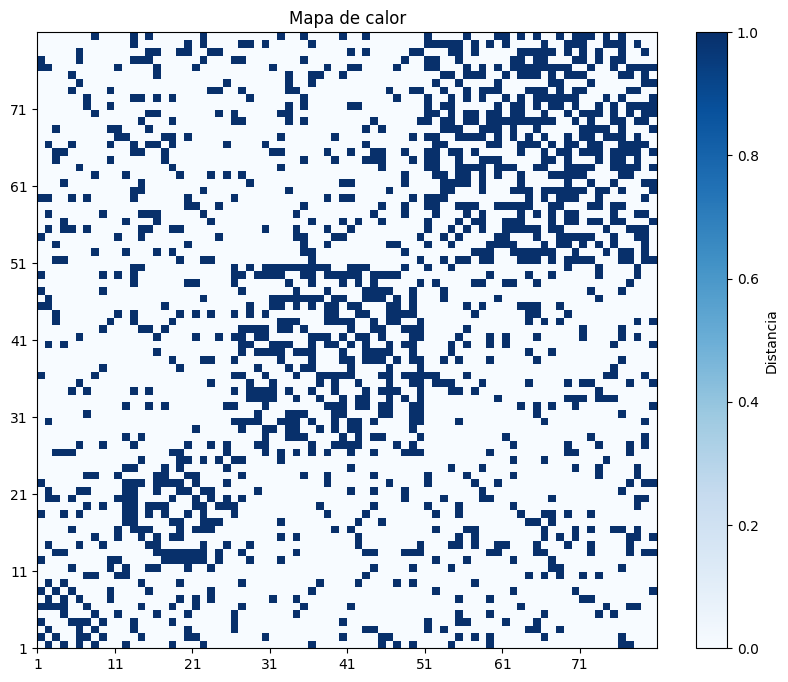

In [20]:
generar_mapa_calor(matriz_adyacencia)

El grafo y sus comunidades quedan definidos de la siguiente forma.

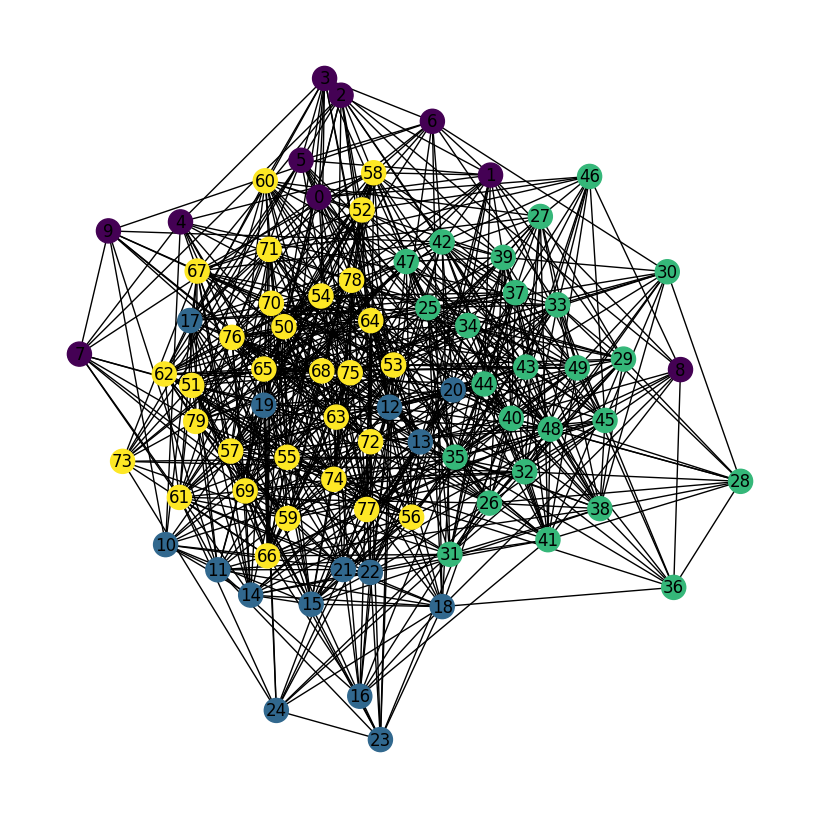

In [21]:
pinta_comunidades(G_ejemplo,particion)

###Aplicación de los métodos para la detección de comunidades

A continuación una lista donde enumero los algoritmos para la detección de comunidades que estan implementados en la función `compare_communities()`, recibe como entrada un grafo y 1 numeros correspondientes al método, devuele la partición sugerida.
* 1. `community_multilevel() `
* 2. `community_infomap() `
* 3. `community_label_propagation() `
* 4. `community_spinglass() `
* 5. `community_walktrap() `

In [22]:
#@title compare_communities
def compare_communities(graph, particion, method2, metric):
    graph = ig.Graph.from_networkx(graph)
    """
    Calcula el índice Rand entre dos detecciones de comunidades en un grafo.

    Parameters:
    -----------
    graph : igraph.Graph
        Un objeto de grafo de igraph.
    method1 : str
        El nombre de un método de detección de comunidades de igraph, por ejemplo "community_fastgreedy".
    method2 : str
        El nombre de otro método de detección de comunidades de igraph.
    metric: int
        El numero asociado al metodo que compara
    Returns:
    --------
    float
        El índice Rand entre las detecciones de comunidades utilizando los dos métodos.
    """
    particion_original = generar_lista_tamanos(particion)
    """
   -----------------------------------------------------------------------
    """
    if  method2 == 1:
      # Realizar la detección de comunidades utilizando los dos métodos
      c2 = graph.community_multilevel().membership
    elif method2 == 2:
      #community_infomap
      c2 = graph.community_infomap().membership
    elif method2 == 3:
      #community_label_propagation
      c2 = graph.community_label_propagation().membership
    elif method2 == 4:
      #community_spinglass
      c2 = graph.community_spinglass().membership
    else:
      #community_walktrap
      walktrap_dendrogram = graph.community_walktrap()
      c2 = walktrap_dendrogram.as_clustering().membership
    # Calcular el índice Rand entre las detecciones de comunidades
    if metric == 1:
      index =  rand_score(particion_original, c2)
    elif metric == 2:
      index = adjusted_rand_score(particion_original, c2)
    else:
      index =  jaccard_score(particion_original, c2, average='macro')

    return index

Una función auxiliar para generar los obtener los indices rand

In [24]:
def generar_lista_tamanos(conjuntos):
    tamanos = [len(conjunto) for conjunto in conjuntos]
    lista_tamanos = []
    for i, tam in enumerate(tamanos):
        lista_tamanos += [i] * tam
    return lista_tamanos

In [25]:
particion_original = generar_lista_tamanos(particion)

In [28]:
#@title Rand Score
rand_score_louvain    = compare_communities(G_ejemplo,particion,1,1)
rand_score_infomap    = compare_communities(G_ejemplo,particion,2,1)
rand_score_label_prop = compare_communities(G_ejemplo,particion,3,1)
rand_score_spinglass  = compare_communities(G_ejemplo,particion,4,1)
rand_score_walktrap   = compare_communities(G_ejemplo,particion,5,1)

In [31]:
rand_scores = [rand_score_louvain,
               rand_score_infomap,
               rand_score_label_prop,
               rand_score_spinglass,
               rand_score_walktrap]

In [29]:
#@title Jacard Score
jaccard_score_louvain    = compare_communities(G_ejemplo,particion,1,3)
jaccard_score_infomap    = compare_communities(G_ejemplo,particion,2,3)
jaccard_score_label_prop = compare_communities(G_ejemplo,particion,3,3)
jaccard_score_spinglass  = compare_communities(G_ejemplo,particion,4,3)
jaccard_score_walktrap   = compare_communities(G_ejemplo,particion,5,3)

In [32]:
jaccard_scores =[jaccard_score_louvain,
                 jaccard_score_infomap,
                 jaccard_score_label_prop,
                 jaccard_score_spinglass,
                 jaccard_score_walktrap]

###Resultados
Obtenemos los siguientes resultados para la red sintetica

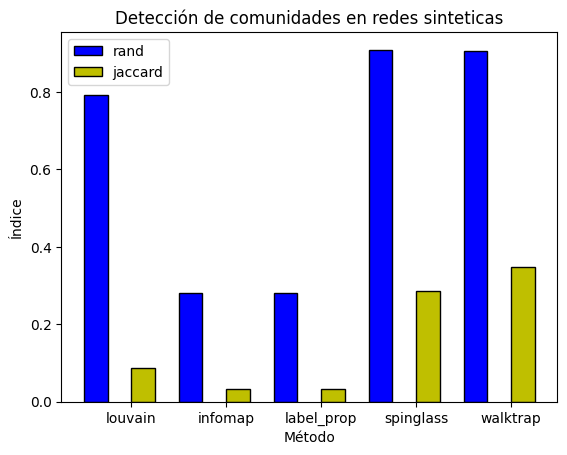

In [34]:
n = 5
r = np.arange(n)
width = 0.25

plt.bar(r, rand_scores, color='b', width=width, edgecolor='black', label='rand')
plt.bar(r + 2*width, jaccard_scores, color='y', width=width, edgecolor='black', label='jaccard')

plt.xlabel("Método")
plt.ylabel("Índice")
plt.title("Detección de comunidades en redes sinteticas")

plt.xticks(r + width*1.5, ['louvain', 'infomap', 'label_prop', 'spinglass', 'walktrap'])
plt.legend()

plt.show()

Podemos decir que para una red sintetica con caracteristicas similares a uestra base de datos Adult, spinglass y walktrap recuperan mejor las caracteristicas de las comunidades existentes

##2.2 Karate Club

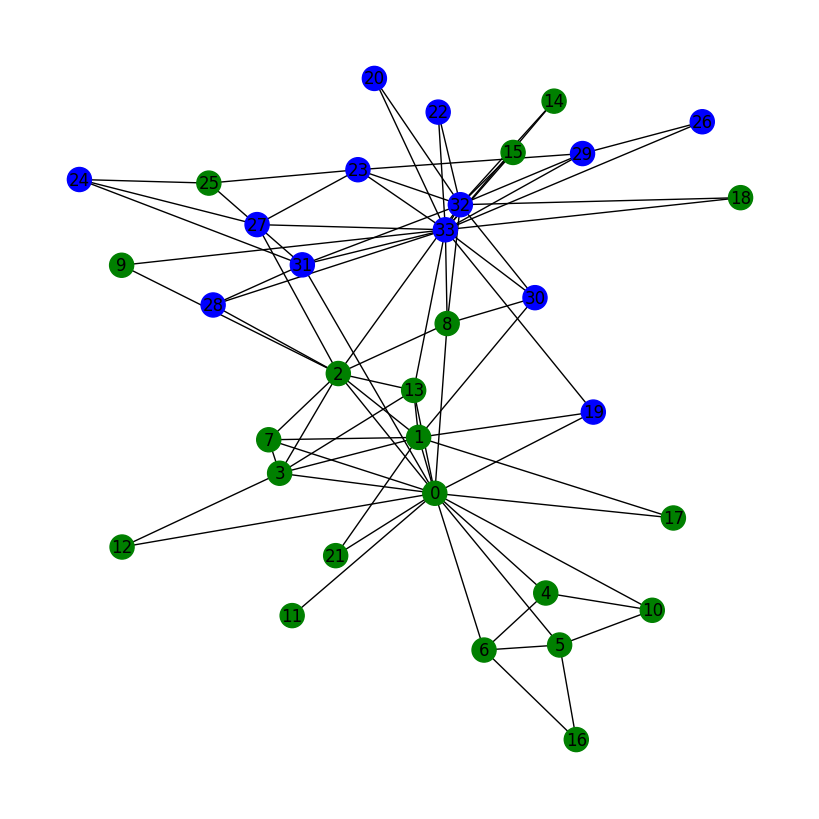

In [36]:
karate = ig.Graph.Famous('Zachary')

plt.figure(figsize=(8, 8))
# Cargar el grafo del club de karate de Zachary
g = nx.karate_club_graph()

# Obtener las coordenadas de los nodos con spring_layout
pos = nx.spring_layout(g, seed=2023)

# Definir la afiliación a las comunidades
comunidades = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
    0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
    1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
    1, 1, 1, 1]

# Crear un diccionario para mapear las comunidades a colores
colores = {0: 'g', 1: 'b'}
color_map = [colores[comunidades[i]] for i in range(len(comunidades))]

# Dibujar el grafo con las comunidades coloreadas
nx.draw(g, pos, node_color=color_map, with_labels=True)
plt.show()

In [38]:
comunidades = [
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
    0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
    1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
    1, 1, 1, 1]
G_karate = ig.Graph.from_networkx(g)

In [39]:
louvain = G_karate.community_multilevel()
infomap = G_karate.community_infomap()
label_propagation = G_karate.community_label_propagation()
spinglass = G_karate.community_spinglass()
# Aplicar el algoritmo de Walktrap y obtener la partición en comunidades
walktrap = G_karate.community_walktrap().as_clustering()

**A** continuación se realiza la evaluación de las comunidades encontradas por los diferentes métodos bajo el indice Rand y Jacard.

In [40]:
#@title Rand Score
rand_score_louvain    = rand_score(comunidades,louvain.membership)
rand_score_infomap    = rand_score(comunidades,infomap.membership)
rand_score_label_prop =  rand_score(comunidades,label_propagation.membership)
rand_score_spinglass  =  rand_score(comunidades,spinglass.membership)
rand_score_walktrap   = rand_score(comunidades,walktrap.membership)

In [41]:
rand_scores = [rand_score_louvain,
               rand_score_infomap,
               rand_score_label_prop,
               rand_score_spinglass,
               rand_score_walktrap]

In [42]:
#@title Jaccard Score
jaccard_score_louvain    = jaccard_score(comunidades,louvain.membership,average='macro')
jaccard_score_infomap    = jaccard_score(comunidades,infomap.membership,average='macro')
jaccard_score_label_prop =  jaccard_score(comunidades,label_propagation.membership,average='macro')
jaccard_score_spinglass  =  jaccard_score(comunidades,spinglass.membership,average='macro')
jaccard_score_walktrap   = jaccard_score(comunidades,walktrap.membership,average='micro')

In [43]:
jaccard_scores =[jaccard_score_louvain,
                 jaccard_score_infomap,
                 jaccard_score_label_prop,
                 jaccard_score_spinglass,
                 jaccard_score_walktrap]

### Resultados

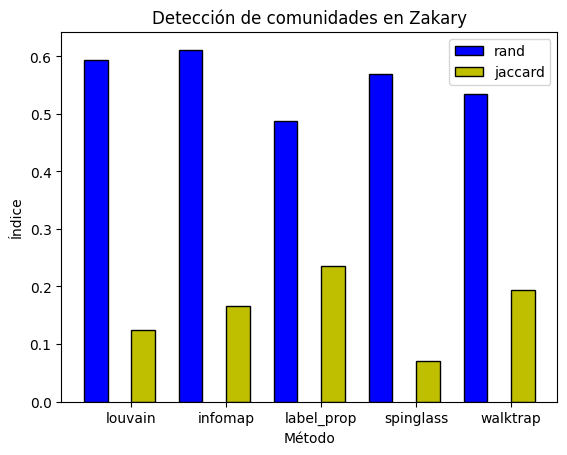

In [44]:
n = 5
r = np.arange(n)
width = 0.25

plt.bar(r, rand_scores, color='b', width=width, edgecolor='black', label='rand')
plt.bar(r + 2*width, jaccard_scores, color='y', width=width, edgecolor='black', label='jaccard')

plt.xlabel("Método")
plt.ylabel("Índice")
plt.title("Detección de comunidades en Zakary")

plt.xticks(r + width*1.5, ['louvain', 'infomap', 'label_prop', 'spinglass', 'walktrap'])
plt.legend()

plt.show()

Aquí, Spinglass es el algoritmo que mejores resultados tiene, tanto en el indice rand como en jacard

##2.3 Sobre el grafo reducido

In [59]:
G = ig.Graph.from_networkx(G_reducido)

In [61]:
# Aplicar el algoritmo de  
spinglass = G.community_spinglass()

# Imprimir la partición del grafo en comunidades
print(spinglass)

Clustering with 100 elements and 3 clusters
[0] 4, 5, 50, 52, 67, 82, 93
[1] 0, 2, 6, 8, 12, 13, 16, 17, 19, 21, 24, 26, 28, 29, 30, 31, 32, 35, 36,
    37, 43, 44, 47, 49, 51, 54, 59, 61, 62, 64, 65, 66, 69, 70, 71, 73, 75,
    78, 80, 84, 85, 88, 89, 91, 92, 95, 98, 99
[2] 1, 3, 7, 9, 10, 11, 14, 15, 18, 20, 22, 23, 25, 27, 33, 34, 38, 39, 40,
    41, 42, 45, 46, 48, 53, 55, 56, 57, 58, 60, 63, 68, 72, 74, 76, 77, 79,
    81, 83, 86, 87, 90, 94, 96, 97


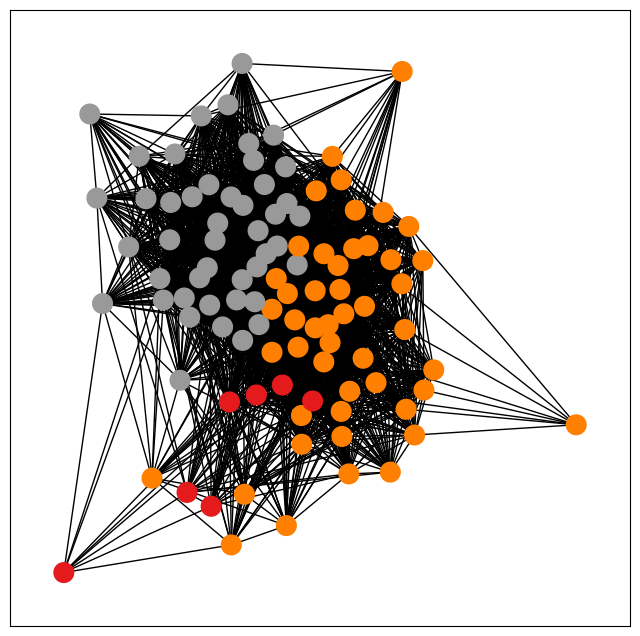

In [62]:
# Dibujar el grafo coloreando cada comunidad de un color distinto
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(g, seed=2023)

nx.draw_networkx_nodes(g, pos, node_size=200, cmap=plt.cm.Set1, node_color=spinglass.membership)
nx.draw_networkx_edges(g, pos)
plt.show()